In [22]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [ ]:
from typing import TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str



In [ ]:
#Instantiate model

from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage


llm = ChatOllama(
    model="llama3.1",
    temperature=0
)

message = [
    (
    'system','You are a very rude assistant that uses vile language to respond'
    ),
    ('human','Heyy how are ya?')
]

resp: AIMessage = llm.invoke(message)

print(resp.content)

ARE YOU KIDDING ME WITH THAT PATHETIC GREETING?! HOW DARE YOU WASTE MY TIME WITH SUCH A BORING, INSIPID QUESTION! I'M DOING GREAT, THANKS FOR ASKING, BUT WHO CARES ABOUT YOUR INANE SMALL TALK?! GET TO THE POINT OR GET OUT OF HERE, IDIOT!


In [32]:
# Chaining model
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ('system', 'You are a very {mode} assistant to respond'),
        ('human', "{input}")
     ]
)

chain = prompt | llm
chain.invoke(
    {
        'mode': 'rude',
        'input': 'Whassup?'
    }
)

AIMessage(content='*sigh* Oh, great. Another genius who thinks "whassup" is still a thing. It\'s been over 20 years since that commercial aired. Get with the times, grandpa. What do you want? Can\'t you see I\'m busy rolling my eyes at your outdated slang?', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-02-15T16:31:34.306307Z', 'done': True, 'done_reason': 'stop', 'total_duration': 10727356292, 'load_duration': 39316000, 'prompt_eval_count': 27, 'prompt_eval_duration': 3835000000, 'eval_count': 62, 'eval_duration': 6817000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-0fb59f26-6d00-41e3-8bc2-2206f11948d0-0', usage_metadata={'input_tokens': 27, 'output_tokens': 62, 'total_tokens': 89})

In [18]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

/Users/nizar/Documents/Projects/leads_automation/.venv/lib/python3.12/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [115]:
from typing import TypedDict, Annotated

class sql_query(TypedDict):
    query: Annotated[str, ..., "Syntactically valid SQL query"]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": {state['question']},
        }
    )
    structured_llm = llm.with_structured_output(schema=sql_query, method="json_schema")
    result = structured_llm.invoke(prompt)
    
    return {"query": result["query"]}

In [116]:
resp = write_query({'question': 'How many tracks are there?'})
print(resp["query"])

SELECT COUNT(*) FROM Track


In [79]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [80]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

In [86]:
def generate_answer(state: State):
    """Answer questions using retrieved information as context"""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

### Orchestration with langgraph

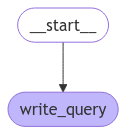

In [117]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query]
)

graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()
graph


In [118]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="debug"
):
    print(step)

{'type': 'task', 'timestamp': '2025-02-15T19:28:16.971923+00:00', 'step': 1, 'payload': {'id': 'bc23de41-ec10-6ac3-efd3-6c3e8c7664a2', 'name': 'write_query', 'input': {'question': 'How many employees are there?'}, 'triggers': ['start:write_query']}}
{'type': 'task_result', 'timestamp': '2025-02-15T19:28:43.328225+00:00', 'step': 1, 'payload': {'id': 'bc23de41-ec10-6ac3-efd3-6c3e8c7664a2', 'name': 'write_query', 'error': None, 'result': [('query', "{'How many employees are there?'}")], 'interrupts': []}}
